In [69]:
%load_ext lab_black
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [70]:
trait = "LDL"
group = "all"
n_q = 5
method = "mean"

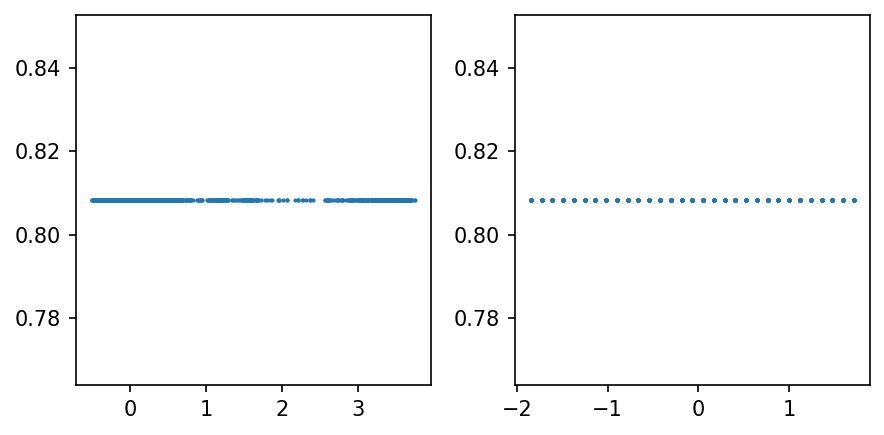

In [71]:
df = pd.read_csv(
    f"out/model/{trait}-{group}/{seed}-{method}.test_info.tsv", sep="\t", index_col=0
)
df["PC1_q"] = pd.qcut(df["PC1"], q=n_q).cat.codes
df_params = pd.read_csv(
    f"out/model/{trait}-{group}/{seed}-{method}.param.tsv", sep="\t", index_col=0
)
fig, axes = plt.subplots(figsize=(6, 3), dpi=150, ncols=2)
axes[0].scatter(df["PC1"], df["cal_predstd"], s=1)
axes[1].scatter(df["AGE"], df["cal_predstd"], s=1)
fig.tight_layout()

# Predictive check

## Across simulations 

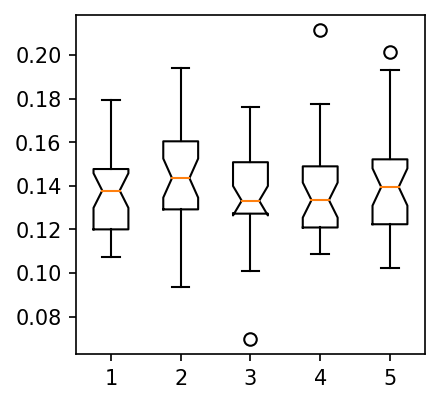

In [72]:
r2_list = []
for seed in range(1, 31):
    df = pd.read_csv(
        f"out/model/{trait}-{group}/{seed}-{method}.test_info.tsv",
        sep="\t",
        index_col=0,
    )
    df_params = pd.read_csv(
        f"out/model/{trait}-{group}/{seed}-{method}.param.tsv", sep="\t", index_col=0
    )
    df["PC1_q"] = pd.qcut(df["PC1"], q=n_q).cat.codes

    # for _ in range(100):
    df["pheno_sim"] = np.random.normal(loc=df["cal_pred"], scale=df["cal_predstd"])
    r2 = df.groupby("PC1_q").apply(
        lambda dfq: stats.pearsonr(dfq["cal_pred"], dfq["pheno_sim"])[0] ** 2
    )
    r2_list.append(r2)
r2_list = pd.concat(r2_list, axis=1).T

fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
ax.boxplot(r2_list, notch=True)
fig.show()

# Individual simulation

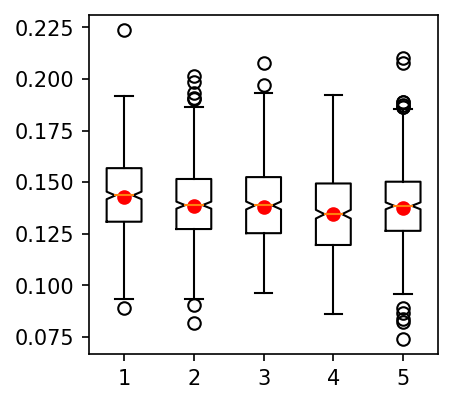

In [73]:
seed = 5
df = pd.read_csv(
    f"out/model/{trait}-{group}/{seed}-{method}.test_info.tsv",
    sep="\t",
    index_col=0,
)
df_params = pd.read_csv(
    f"out/model/{trait}-{group}/{seed}-{method}.param.tsv", sep="\t", index_col=0
)

df["PC1_q"] = pd.qcut(df["PC1"], q=n_q).cat.codes
df["const"] = 1
r2_list = []

for _ in range(500):
    df["pheno_sim"] = np.random.normal(loc=df["cal_pred"], scale=df["cal_predstd"])
    r2 = df.groupby("PC1_q").apply(
        lambda dfq: stats.pearsonr(dfq["cal_pred"], dfq["pheno_sim"])[0] ** 2
    )
    r2_list.append(r2)
r2_list = pd.concat(r2_list, axis=1).T

fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
ax.boxplot(r2_list, notch=True)
ax.scatter(
    np.arange(1, 6),
    df.groupby("PC1_q").apply(
        lambda dfq: np.var(dfq["cal_pred"])
        / (np.var(dfq["cal_pred"]) + dfq["cal_predstd"].iloc[0] ** 2)
    ),
    color="red",
)
fig.show()

In [74]:
covar = df[df_params.index]
beta = df_params["mean_beta"]
wgt_covar = covar * beta
pred = covar.dot(beta)

In [75]:
df_plot = []
for i, (_, dfq) in enumerate(df.groupby("PC1_q")):
    index = dfq.index
    pred_var = pred[index].var()
    wgt_covar_cov = wgt_covar.loc[index, :].cov().stack().reset_index()
    wgt_covar_cov = pd.Series(
        wgt_covar_cov.iloc[:, 2].values,
        index=wgt_covar_cov["level_0"] + "x" + wgt_covar_cov["level_1"],
    )
    print(
        f"{i + 1}: {pred[index].var():.3g}, {wgt_covar_cov.sum():.3g}"
        #         f"{2 * wgt_covar_cov['PGSxPGS*PC1']:.2g}, {wgt_covar.loc[index, ['PGS', 'PGS*PC1']].sum(axis=1).var():.2g}"
    )
    wgt_covar_cov["pred_var"] = pred_var
    df_plot.append(wgt_covar_cov)
df_plot = pd.DataFrame(df_plot)

1: 0.109, 0.109
2: 0.105, 0.105
3: 0.105, 0.105
4: 0.102, 0.102
5: 0.104, 0.104


In [76]:
display(
    df.groupby("PC1_q").apply(
        lambda dfq: stats.pearsonr(dfq["cal_pred"], dfq["pheno"])[0] ** 2
    )
)
display(df.groupby("PC1_q").apply(lambda dfq: np.var(dfq["cal_pred"])))

PC1_q
0    0.150351
1    0.160112
2    0.160862
3    0.108825
4    0.052413
dtype: float64

PC1_q
0    0.108630
1    0.105155
2    0.104697
3    0.101625
4    0.104240
dtype: float64

1: y = 1 x + -0.17; R2=0.15; std(resid)=0.82; std(fitted_resid)=0.82; std(x)=0.33; std(y)=0.889; cov(x,y)=0.114
2: y = 1.1 x + -0.16; R2=0.16; std(resid)=0.781; std(fitted_resid)=0.781; std(x)=0.324; std(y)=0.852; cov(x,y)=0.111
3: y = 1.1 x + -0.19; R2=0.161; std(resid)=0.782; std(fitted_resid)=0.782; std(x)=0.324; std(y)=0.854; cov(x,y)=0.111
4: y = 0.89 x + 0.42; R2=0.109; std(resid)=0.812; std(fitted_resid)=0.813; std(x)=0.319; std(y)=0.86; cov(x,y)=0.0906
5: y = 0.6 x + 1.4; R2=0.0524; std(resid)=0.818; std(fitted_resid)=0.828; std(x)=0.323; std(y)=0.84; cov(x,y)=0.0622


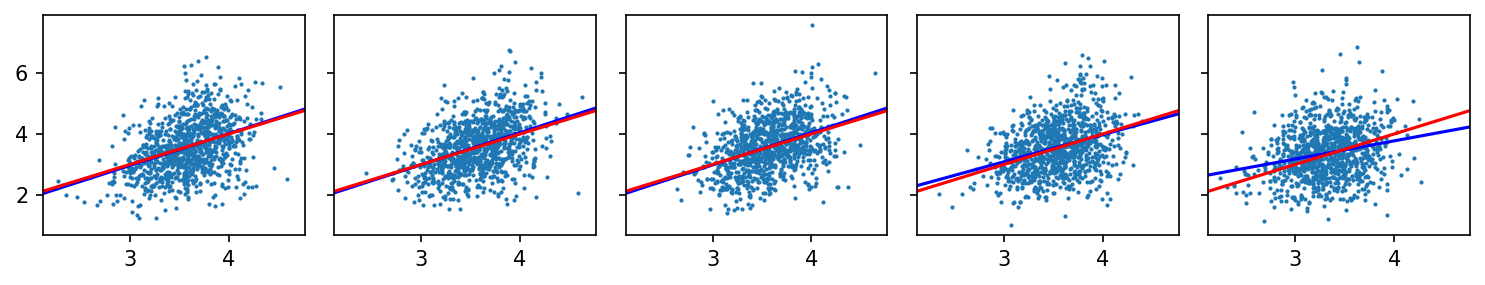

In [77]:
fig, axes = plt.subplots(
    figsize=(n_q * 2, 2), dpi=150, ncols=n_q, sharex=True, sharey=True
)
for i, (q, dfq) in enumerate(df.groupby("PC1_q")):
    ax = axes[i]
    x, y = dfq["cal_pred"], dfq["pheno"]
    ax.scatter(x=x, y=y, s=1)
    model = sm.OLS(endog=y, exog=sm.add_constant(x)).fit()
    mid_x = np.mean(x)
    ax.axline(
        (mid_x, model.params[0] + model.params[1] * mid_x),
        slope=model.params[1],
        color="blue",
    )
    ax.axline((mid_x, mid_x), slope=1, color="red")

    print(
        f"{i + 1}: y = {model.params[1]:.2g} x + {model.params[0]:.2g}; "
        f"R2={model.rsquared:.3g}; "
        f"std(resid)={np.std(model.resid):.3g}; "
        f"std(fitted_resid)={np.std(y - x):.3g}; "
        f"std(x)={np.std(x):.3g}; "
        f"std(y)={np.std(y):.3g}; "
        f"cov(x,y)={np.cov(x,y)[0, 1]:.3g}"
    )

fig.tight_layout()